<a href="https://colab.research.google.com/github/ddg93/JOposeAABB/blob/main/AABB_poseEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# import useful modules
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Input, GaussianNoise
import matplotlib.pyplot as plt

In [6]:
#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# download the AABB list for the CYL10 particle: fibre, r=9.01
!gdown 1OUFkUHou1ZedKTZVm30gtnm3FTnjqZmq -O /boxlist.txt

Downloading...
From: https://drive.google.com/uc?id=1OUFkUHou1ZedKTZVm30gtnm3FTnjqZmq
To: /boxlist.txt
100% 29.2M/29.2M [00:00<00:00, 180MB/s]


In [16]:
# load the data from the file
ref = np.loadtxt('/boxlist.txt') #load the virtual list of bounding boxes
# separate the AABB components
X = abs(ref[:,3:6])
# and the two polar angles
org_angls = ref[:,:2]
# and the particle orientation vector
Y = abs(ref[:,6:])

In [18]:
# split between training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [19]:
# define a custom norm-2 loss over the predicted values
def custom_loss(y_true,y_pred):
    # norm 2 of the difference between predicted and true particle orientation vectors 
    norm = tf.norm((y_true-y_pred),axis=-1)
    loss = tf.math.reduce_sum(norm) #reduction sum
    # add a penalty term that is non-zero if any component of the predicted orientation vector is lower than zero or greater than one
    zero = tf.constant([0.0]) #define the zero constant value
    penalty = tf.math.less(y_pred, zero) #calculate the penalty
    pen = tf.math.reduce_sum(tf.cast(penalty,tf.int32)) #reduction sum
    return loss + tf.cast(pen, tf.float32) #calculate the total loss

In [26]:
# Build the model: input_size=3 (AABB); output size=3 (direction vector of the particle)
input_layer = Input(shape=3)
g_noise = GaussianNoise(0.1)(input_layer) #Gaussian noise
dense_layer_1 = Dense(256, kernel_initializer='he_uniform', activation='relu')(g_noise) #1st dense layer
dense_layer_2 = Dense(256, kernel_initializer='he_uniform', activation='relu')(dense_layer_1) #2nd dense layer
dense_layer_3 = Dense(256, kernel_initializer='he_uniform', activation='relu')(dense_layer_2) #3rd dense layer
small_dense = Dense(3)(dense_layer_3) #layer of size 3
output = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x,axis=-1,epsilon=1e-12))(small_dense) #lambda layer to impose Euclideian norm = 1

In [27]:
# assemble the model
model = Model(inputs=input_layer, outputs=output)
# compile the model imposing the custom_loss
model.compile(loss=custom_loss, optimizer="adam", metrics=["accuracy"])
# report of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 3)                0         
 oise)                                                           
                                                                 
 dense_4 (Dense)             (None, 256)               1024      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                           

In [28]:
# Fit the model
model.fit(X_train, Y_train, epochs=10, batch_size=128,  verbose=1)
# Calculate predictions
# train set
PredTestSet = model.predict(X_train)
# test set
PredValSet = model.predict(X_test)

Epoch 1/10
810/810 [==============================] - 4s 3ms/step - loss: 5.1938 - accuracy: 0.9837
Epoch 2/10
810/810 [==============================] - 3s 4ms/step - loss: 2.6483 - accuracy: 0.9938
Epoch 3/10
810/810 [==============================] - 3s 3ms/step - loss: 2.3922 - accuracy: 0.9940
Epoch 4/10
810/810 [==============================] - 3s 4ms/step - loss: 2.3258 - accuracy: 0.9937
Epoch 5/10
810/810 [==============================] - 3s 3ms/step - loss: 2.2791 - accuracy: 0.9943
Epoch 6/10
810/810 [==============================] - 3s 4ms/step - loss: 2.2581 - accuracy: 0.9938
Epoch 7/10
810/810 [==============================] - 3s 3ms/step - loss: 2.1800 - accuracy: 0.9940
Epoch 8/10
810/810 [==============================] - 3s 3ms/step - loss: 2.1359 - accuracy: 0.9943
Epoch 9/10
810/810 [==============================] - 3s 3ms/step - loss: 2.1632 - accuracy: 0.9946
Epoch 10/10
810/810 [==============================] - 2s 2ms/step


In [29]:
# store the test result
res = []
for i in range(X_test.shape[0]):
    line = np.concatenate((X_test[i,:],Y_test[i,:],PredValSet[i,:]))
    res.append(line)
res = np.array(res)

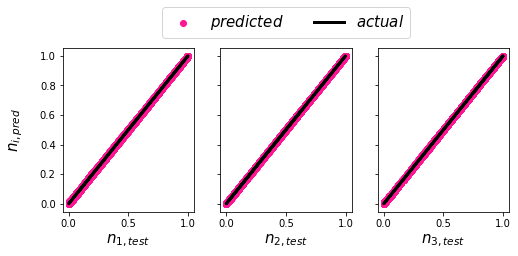

In [56]:
fig,axs = plt.subplots(1,3,figsize=(8,3),sharey=True)
#plot the predicted and actual values of the three components 
# of the particle orientation vector
#n1
axs[0].scatter(Y_test[:,0],PredValSet[:,0],label=r'$\mathit{predicted}$',c='deeppink')
axs[0].plot(Y_test[:,0],Y_test[:,0],color='k',label=r'$\mathit{actual}$',lw=3)
#n2
axs[1].scatter(Y_test[:,1],PredValSet[:,1],label=r'$\mathit{predicted}$',c='deeppink')
axs[1].plot(Y_test[:,1],Y_test[:,1],color='k',label=r'$\mathit{actual}$',lw=3)
#n3
axs[2].scatter(Y_test[:,2],PredValSet[:,2],c='deeppink')
axs[2].plot(Y_test[:,2],Y_test[:,2],color='k',lw=3)
# Format
axs[0].set_ylabel(r'$\mathit{n_{i,pred}}$',fontsize=15,labelpad=15)
axs[0].set_xlabel(r'$\mathit{n_{1,test}}$',rotation=0,fontsize=15)
axs[1].set_xlabel(r'$\mathit{n_{2,test}}$',rotation=0,fontsize=15)
axs[2].set_xlabel(r'$\mathit{n_{3,test}}$',rotation=0,fontsize=15)
# plot the legend
axs[1].legend(bbox_to_anchor=(1.5,1.3),ncol=2,fontsize=15)